### Initialization

In [1]:
import numpy as np
import pandas as pd

import os
import scipy.sparse as sps
from surprise import Dataset, Reader
from surprise import SVD, SVDpp, NMF,KNNBaseline, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate

from sklearn.preprocessing import normalize

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,5
sb.set_style(style='darkgrid')

### * CVX solver

In [181]:
def cvxSolver(R_sa,M):
    import cvxpy as cp
    solver = 'cvx'
    m, n = R_sa.shape   # Number of accounts and movies
    O = np.array(R_sa != 0,dtype='float')   # Producing Observation matrix 
    k = M.shape[0]   # Number of features

    X = cp.Variable(shape=(m, k))
    constraint = [X >= 0]

    obj = cp.Minimize(cp.norm(R_sa - cp.multiply(O,(X@M)),'fro'))

    prob = cp.Problem(obj, constraint)
    prob.solve()
    A_hat = X.value
    return A_hat

In [180]:
def cvxSolver_improved(R_sa, M):
    import cvxpy as cp
    m, n = R_sa.shape   # Number of accounts and movies
    O = np.array(R_sa != 0,dtype='float')   # Producing Observation matrix 
    k = M.shape[0]   # Number of features
    R = R_sa.astype(np.float32)  # rating matrix R
    V = M.astype(np.float32)  # Known item feature matrix V
    V_constant = cp.Parameter((k, n), value=V)

    U = cp.Variable((m, k), nonneg=True)  # Ensures U is non-negative
    objective = cp.Minimize(cp.norm(R - cp.multiply(O,(U @ V_constant)), 'fro') + 0.1 * cp.norm(U, 1))
    problem = cp.Problem(objective)
    result = problem.solve(solver=cp.SCS)
    A = U.value
    return A

### * nimfa solver

In [4]:
def NimfaSolver(R_sa, k=4, max_iter = 100):
    import nimfa
    nmf = nimfa.Nmf(R_sa, rank=k, max_iter=max_iter)
    nmf_fit = nmf()
    A = nmf_fit.basis()
    MN = nmf_fit.coef()
    return np.asarray(A), np.asarray(MN)

### Neural Network solver

In [179]:
def ANNsolver(R_sa, M, n_iterations=1000):
    import tensorflow as tf

    R = R_sa.astype(np.float32)
    M = M.astype(np.float32)

    m, k, n = R.shape[0], M.shape[0], R.shape[1]

    # Convert M to a TensorFlow constant
    M_tensor = tf.constant(M, dtype=tf.float32)

    # TensorFlow Dataset to manage batches of R
    dataset = tf.data.Dataset.from_tensor_slices(R)
    dataset = dataset.batch(32)

    # Create a trainable variable for X
    X = tf.Variable(tf.random.normal([m, k], stddev=0.1), dtype=tf.float32)

    # Define the optimizer
    optimizer = tf.optimizers.Adam(learning_rate=1e-4)

    # Define the training step
    @tf.function
    def train_step(R_batch, indices):
        with tf.GradientTape() as tape:
            # Fetch the corresponding batch from X
            X_batch = tf.gather(X, indices)
            # Predict R for this batch using the corresponding X_batch and M
            R_pred = tf.matmul(X_batch, M_tensor)
            # Calculate the loss (Frobenius norm of the error)
            loss = tf.reduce_mean(tf.square(R_batch - R_pred))
        # Compute the gradients for X_batch
        gradients = tape.gradient(loss, [X_batch])
        # Apply gradients to the corresponding part of X
        optimizer.apply_gradients([(tf.IndexedSlices(gradients[0], indices), X)])
        return loss

    # Training loop
    epochs = n_iterations
    for epoch in range(epochs):
        for step, (R_batch) in enumerate(dataset):
            # Create indices for the current batch
            batch_indices = tf.range(step * 32, min((step + 1) * 32, m))
            loss = train_step(R_batch, batch_indices)
    #       if step % 100 == 0:
    #             print(f"Epoch {epoch}, Step {step}, Loss: {loss.numpy()}")
    return X.numpy()

__________________

In [5]:
def project_onto_face(A = 'array_like_matrix',l=0.9):
    m,n = A.shape
    P = np.zeros((m,n),dtype='float')
    for i in range(m):
        P[i] = np.array(A[i] >= l*A[i].max(),dtype='float')
    return P

In [6]:
def BinarizingM(matrix,l=0.5):
    normalized_matrix = normalize(matrix.T, axis=1, norm='l1')
    a = project_onto_face(normalized_matrix,l)
    return a.T

# Rn: reconstructing ratings

In [7]:
def Demix(R_sa, A, A_B, MN):
    R = []
    Rn = []
    for account_index in range(A.shape[0]):
        account_ratings = []
        T= np.zeros((A.shape[1],MN.shape[1]))
        for k in range(A.shape[1]):
            for j in range(MN.shape[1]):
                T[k,j]=A[account_index,k]*MN[k,j]

        P = np.reshape(A_B[account_index],(-1,1))*T
        P = np.delete(P,np.where(A_B[account_index]==0),axis=0)
        P = normalize(P, axis=0, norm='l1')
        
        for i in range(P.shape[0]):
            account_ratings.append(R_sa[account_index]*P[i])
        R.append(np.round(account_ratings,1))
        for u in range(len(R[account_index])):
            Rn.append(R[account_index][u])
    return np.array(Rn)

In [8]:
def Decompose(R_sa, A, A_B):
    '''
    To reconstruct shared ratings based on account membership
    '''
    p=0
    P=[]
    RrN=[]
    
    m = A.shape[0]
    for i in range(m):
        p = A[i]*A_B[i]
        p = p[p !=0]
        p = normalize(np.reshape(p,(-1,1)),axis=0,norm='l1')
        RrN.append(np.round(p * R_sa[i]))
        P.append(p)
    Rn=[]
    for i in range(m):
        for u in range(len(RrN[i])):
            Rn.append(RrN[i][u])
    return np.array(Rn)

with movie features

In [ ]:
def Decompose2(R_sa, A, A_B):
    p=0
    P=[]
    RrN=[]
    
    m = A.shape[0]
    for i in range(m):
        p = A[i]*A_B[i]
        p = p[p !=0]
        p = p * MN
        p = normalize(p,axis=0,norm='l1')
        RrN.append(np.round(p * R_sa[i]))
        P.append(p)
    Rn=[]
    for i in range(m):
        for u in range(len(RrN[i])):
            Rn.append(RrN[i][u])
    return np.array(Rn), P

### Mapping

In [9]:
# To find which real users of R are in an account
def UsersIn_a(a='account index'):
    for value in SA.iloc[np.where((SA['are mixed in row of R_sa']) == a)].iloc[:,1]:
        return value

# To find where are the decomposed users of account a
def DecomposedUsersOf_a(a):
    t=0
    for i in range(a+1):
        t += int(A_B[i].sum())
    return (int(t-A_B[i].sum()+1),t)

def IdentifiedMapping(account_index='the account index of R_sa'):
    '''
    this function show the map of real users that were mixed in the given account to the identified users in Rn: the new reconstructed matrix'
    Out put : [users or rows of R, algorithm Decomposed their shared account to these rows or Rn]
    '''
    ground_truth = UsersIn_a(account_index)
    identified = [i-1 for i in range(DecomposedUsersOf_a(account_index)[0],DecomposedUsersOf_a(account_index)[1]+1)]
    return identified, ground_truth
# identified, ground_truth = IdentifiedMapping(a)

### Evaluation methods

In [10]:
def ComputeRowSimilarity(identified, ground_truth):
    n = len(identified)
    num_agree = np.sum(identified == ground_truth)
    similarity = max(num_agree/n,1-num_agree/n)
#     similarity = num_agree/n
    return np.round(similarity,4)

def ComputeSimilarity(A_B='account membership matrix',Rn='Recunstructed ratings', R='real ratings'):
    best_pairs = []
    for account_index in range(A_B.shape[0]):
        identified, ground_truth = IdentifiedMapping(account_index)
        gt=ground_truth.copy()
        if len(identified)<len(ground_truth):
            for i in range(len(ground_truth)-len(identified)):
                identified.append(identified[0])
        for u in identified:
            sim_u = []
            for t in gt:
                sim_u.append([u, t, ComputeRowSimilarity(Rn[u],R[t])])
            s = []
            best = []
            best_pair_for_identified = []
            for i in range(len(sim_u)):
                s.append(sim_u[i][2])
            best.append([np.argmax(s),max(s)])
            best_pair_for_identified.append(sim_u[best[0][0]])
            gt.remove(best_pair_for_identified[0][1])
            best_pairs.append(best_pair_for_identified[0])
            if len(gt)==0:
                    break
    return best_pairs

In [11]:
# Rr = sps.coo_matrix(np.array(pd.read_csv('InputData/Rr.csv').loc[:,'0':'1679'],dtype='float'))
def ComputeRMSE(R):
    R = sps.coo_matrix(R)
    R = pd.DataFrame({'CharacterID': R.row , 'MovieID': R.col , 'Rating': R.data})
    reader = Reader()
    data = Dataset.load_from_df(R,reader)
    algo = BaselineOnly()
#     algo = CoClustering()
    # algo = SVD()
#     algo = KNNBaseline()
    output = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
    return np.round(output['test_rmse'].mean(),4)

def ComputeRMSE_vectors(prediction,target):
    return np.round(np.sqrt(((prediction-target)**2).mean()),4)

def cosine_similarity(vector1, vector2):
    return np.round(((np.dot(vector1,vector2))/(np.linalg.norm(vector1)*np.linalg.norm(vector2))),4)

In [12]:
def UserIdentificationMeasure(SA = 'ground truth mapping', A_B = 'account membership matrix'):
    ''' SA :mapping of merging accounts',A_hat_B'account membership matrix '''
    A_B = pd.DataFrame(A_B)
    TP1, TN1, FP1, FN1 = 0,0,0,0
    for i in range(SA.shape[0]):
        if len(SA["rows of R"][i]) == 1:   #اگه واقعا تک کاربره بود
            if A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 1 :   # الگوریتم تک کاربره شناساییش کرده بود
                TP1 +=1
            else:   # الگوریتم تک کاربره شناساییش نکرده بود
                FN1 +=1
        else:                            #اگه واقعا تک کاربره نبود
            if A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 1 :   # الگوریتم تک کاربره شناساییش کرده بود
                FP1 +=1
            else:   # الگوریتم تک کاربره شناساییش نکرده بود
                TN1 +=1   
    precision1 = np.round(TP1 / (TP1 + FP1),2)
    accuracy1 = np.round((TP1 + TN1) / (TP1 + TN1 + FP1 + FN1),2)


    TP2, TN2, FP2, FN2 = 0,0,0,0
    for i in range(SA.shape[0]):
        if len(SA["rows of R"][i]) == 2:                      #اگه واقعا دو کاربره بود
            if A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 2 :   # الگوریتم دو کاربره شناساییش کرده بود
                TP2 +=1
            else:                                           # الگوریتم دو کاربره شناساییش نکرده بود
                FN2 +=1
        else:                                               #اگه واقعا دو کاربره نبود
            if A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 2 :   # الگوریتم دو کاربره شناساییش کرده بود
                FP2 +=1
            else:                                           # الگوریتم دو کاربره شناساییش نکرده بود
                TN2 +=1   
    precision2 = np.round(TP2 / (TP2 + FP2),2)
    accuracy2 = np.round((TP2 + TN2) / (TP2 + TN2 + FP2 + FN2),2)


    TP3, TN3, FP3, FN3 = 0,0,0,0
    for i in range(SA.shape[0]):
        if len(SA["rows of R"][i]) == 3:                      #اگه واقعا 3 کاربره بود
            if A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 3 :   # الگوریتم 3 کاربره شناساییش کرده بود
                TP3 +=1
            else:                                           # الگوریتم 3 کاربره شناساییش نکرده بود
                FN3 +=1
        else:                                               #اگه واقعا 3 کاربره نبود
            if A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 3 :   # الگوریتم 3 کاربره شناساییش کرده بود
                FP3 +=1
            else:                                           # الگوریتم 3 کاربره شناساییش نکرده بود
                TN3 +=1   
    try:
        precision3 = np.round(TP3 / (TP3 + FP3),2)
    except ZeroDivisionError:
        precision3 = 0
    accuracy3 = np.round((TP3 + TN3) / (TP3 + TN3 + FP3 + FN3),2)


    TP4, TN4, FP4, FN4 = 0,0,0,0
    for i in range(SA.shape[0]):
        if len(SA["rows of R"][i]) == 4:                      #اگه واقعا 4 کاربره بود
            if A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 4 :   # الگوریتم 4 کاربره شناساییش کرده بود
                TP4 +=1
            else:                                           # الگوریتم 4 کاربره شناساییش نکرده بود
                FN4 +=1
        else:                                               #اگه واقعا 4 کاربره نبود
            if A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 4 :   # الگوریتم 4 کاربره شناساییش کرده بود
                FP4 +=1
            else:                                           # الگوریتم 4 کاربره شناساییش نکرده بود
                TN4 +=1   
    try:
        precision4 = np.round(TP4 / (TP4 + FP4),2)
    except ZeroDivisionError:
        precision4 = 0
    accuracy4 = np.round((TP4 + TN4) / (TP4 + TN4 + FP4 + FN4),2)
    
    data = [[precision1, precision2, precision3, precision4,],[accuracy1,accuracy2,accuracy3, accuracy4]]
    col = ['singleUser Accounts', 'TwoUser  Accounts', 'ThreeUser  Accounts', 'FourUser  Accounts']
    row = ['precision', 'accuracy']
    table = pd.DataFrame(data, index=row, columns=col)
    return table

In [13]:
def Confusion(SA = 'ground truth mapping', A_B = 'account membership matrix'):
    ''' SA :mapping of merging accounts',A_hat_B'account membership matrix '''
    A_B = pd.DataFrame(A_B)
    T1I1, T1I2, T1I3, T1I4= 0,0,0,0
    T2I1, T2I2, T2I3, T2I4= 0,0,0,0
    T3I1, T3I2, T3I3, T3I4= 0,0,0,0
    T4I1, T4I2, T4I3, T4I4= 0,0,0,0

    for i in range(SA.shape[0]):
        if len(SA["rows of R"][i]) == 1:
            if A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 1 :
                T1I1 +=1
            elif A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 2 :
                T1I2 +=1
            elif A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 3 :
                T1I3 +=1
            elif A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 4 :
                T1I4 +=1
        elif len(SA["rows of R"][i]) == 2:
            if A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 1 :
                T2I1 +=1
            elif A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 2 :
                T2I2 +=1
            elif A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 3 :
                T2I3 +=1
            elif A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 4 :
                T2I4 +=1
        elif len(SA["rows of R"][i]) == 3:
            if A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 1 :
                T3I1 +=1
            elif A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 2 :
                T3I2 +=1
            elif A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 3 :
                T3I3 +=1
            elif A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 4 :
                T3I4 +=1
        elif len(SA["rows of R"][i]) == 4:
            if A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 1 :
                T4I1 +=1
            elif A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 2 :
                T4I2 +=1
            elif A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 3 :
                T4I3 +=1
            elif A_B.iloc[SA['are mixed in row of R_sa'][i]].sum() == 4 :
                T4I4 +=1

    data = [[T1I1, T1I2, T1I3, T1I4],
            [T2I1, T2I2, T2I3, T2I4],
            [T3I1, T3I2, T3I3, T3I4],
            [T4I1, T4I2, T4I3, T4I4]]

    col = ['singleUser', 'TwoUser', 'ThreeUser', 'FourUser']
    row = ['singleUser', 'TwoUser', 'ThreeUser', 'FourUser']
    table = pd.DataFrame(data, index=row, columns=col)
    return table

__________________________________________

### Movie Lens 100k Input Data & shared version

In [14]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
m_g_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation'
           , 'Children', 'Comedy','Crime', 'Documentary', 'Drama', 'Fantasy'
           , 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


data_set_path_users = "InputData/ml-100k/u.user"
data_set_path_ratings = "InputData/ml-100k/u.data"
data_set_path_movies = "InputData/ml-100k/u.item"
users = pd.read_csv(data_set_path_users,sep='|',names = u_cols)
ratings = pd.read_csv(data_set_path_ratings,sep='\t', names = r_cols).drop('timestamp',axis=1)
movies = pd.read_csv(data_set_path_movies, sep='|', names = m_cols, usecols=range(5))
movies_genre_df = pd.read_csv(data_set_path_movies, sep='|', names = m_g_cols).drop(['title', 'release_date', 'video_release_date', 'imdb_url'],axis=1)

### Cleaning Data set

In [15]:
# cleaning the unknown items(movie) from our data - when we have the features of the items we can wok on it
# wherein our focosed feature is the genre of the movie so we find the movies with unknow genre and remove it from our dfs
movie_ids_to_be_removed = list(movies_genre_df[movies_genre_df['unknown'] == 1]['movie_id'])
for ids in movie_ids_to_be_removed:
    ratings.drop((ratings[ratings['movie_id'] == ids]).index, inplace=True)
    movies.drop((movies[movies['movie_id'] == ids]).index, inplace=True)
    movies_genre_df.drop((movies_genre_df[movies_genre_df['movie_id'] == ids]).index, inplace=True)  
# To Test run the code below
# ratings.iloc[ratings[ratings['movie_id'] == ids].index]

### Bulding Movie-Character Matrix

In [997]:
# G : Movie-Genre Matrix
# W : Genre-Character Matrix
# M : Movie-Character Matrix
G = np.array(movies_genre_df.drop(['movie_id','unknown'],axis=1))

W = np.array(pd.read_csv('InputData/W_clustered_normal.csv'))[0:18,1:5]
weighting = 'Clustering'

# W = np.array(pd.read_csv('InputData/W_accounts_clustered_normal.csv'))[0:18,1:5]
# weighting = 'Accounts Clustered'


# W = np.array(pd.read_csv('InputData/W4c.csv'))[0:18,1:5]
# weighting = 'Wuhr'

M = np.array(np.dot(G,W).T,dtype='float')
# pd.DataFrame(M).to_csv('InputData/M_clustering.csv')
# pd.DataFrame(M).to_csv('InputData/M_wuhr.csv')

### Input: Dataset Loading Account-Movie Ratings Matrix R_sa

In [838]:
# R_SAD4:    The Rating matrix of Shared Account Dataset with 4 user type mixture
# R_SAD_NC:  The Rating matrix of Shared account with no collision assumption
# GT_SAD4:   The Ground Truth Mapping of Shared Account Dataset with 4 user type mixture generaated
# GT_SAD_NC: The Ground Truth Mapping of Shared Account with no collision assumption
R = np.array(pd.read_csv('InputData/R.csv').loc[:,'1':'1682'],dtype='float')

def R_SAD_2U_sum():
    R_sa = np.array(pd.read_csv('InputData/R_SAD_2U.csv').loc[:,'0':'1679'],dtype='float')
    SA = pd.read_csv("InputData/GT_SAD_2U.csv")   # Ground truth mapping
    SA['rows of R'] = SA['rows of R'].apply(lambda x: [int(i) for i in x.strip('[').strip(']').split(', ')])   # Splitting the 'rows of' column into lists of integers
    dataset_name = 'R_SAD_2U_sum'
    lA = 0.77
    return R_sa, SA, lA, dataset_name


def R_SAD_Extra():
    R_sa = np.array(pd.read_csv('InputData/R_SAD_Extra.csv').loc[:,'0':'1679'],dtype='float')
    SA = pd.read_csv("InputData/GT_SAD_Extra.csv")   # Ground truth mapping
    SA['rows of R'] = SA['rows of R'].apply(lambda x: [int(i) for i in x.strip('[').strip(']').split(', ')])   # Splitting the 'rows of' column into lists of integers
    dataset_name = 'R_SAD_Extra'
    lA = 0.77
    return R_sa, SA, lA, dataset_name

def R_SAD_NC():
    R_sa = np.array(pd.read_csv('InputData/R_SAD_NC.csv').loc[:,'0':'1679'],dtype='float')
    SA = pd.read_csv("InputData/GT_SAD_NC.csv")   # Ground truth mapping
    SA['rows of R'] = SA['rows of R'].apply(lambda x: [int(i) for i in x.strip('[').strip(']').split(', ')])   # Splitting the 'rows of' column into lists of integers
    dataset_name = 'R_SAD_NC'
    lA = 0.77
    return R_sa, SA, lA, dataset_name


def R_SAD4_WC():
    R_sa = np.array(pd.read_csv('InputData/R_SAD4.csv').loc[:,'0':'1679'],dtype='float')
    SA = pd.read_csv("InputData/GT_SAD4.csv")   # Ground truth mapping
    SA['rows of R'] = SA['rows of R'].apply(lambda x: [int(i) for i in x.strip('[').strip(']').split(', ')])   # Splitting the 'rows of' column into lists of integers
    dataset_name = 'R_SAD4_WC'
    lA = 0.735
    return R_sa, SA, lA, dataset_name


def R_SAD_4C_sum():
    R_sa = np.array(pd.read_csv('InputData/R_SAD_4C_sum.csv').loc[:,'0':'1679'],dtype='float')
    SA = pd.read_csv("InputData/GT_SAD_4C_sum.csv")   # Ground truth mapping
    SA['rows of R'] = SA['rows of R'].apply(lambda x: [int(i) for i in x.strip('[').strip(']').split(', ')])   # Splitting the 'rows of' column into lists of integers
    dataset_name = 'R_SAD_4Clusters'
    lA = 0.77
    return R_sa, SA, lA, dataset_name

def R_SAD_4C_mean():
    R_sa = np.array(pd.read_csv('InputData/R_SAD_4C_mean.csv').loc[:,'0':'1679'],dtype='float')
    SA = pd.read_csv("InputData/GT_SAD_4C_mean.csv")   # Ground truth mapping
    SA['rows of R'] = SA['rows of R'].apply(lambda x: [int(i) for i in x.strip('[').strip(']').split(', ')])   # Splitting the 'rows of' column into lists of integers
    dataset_name = 'R_SAD_4Clusters'
    lA = 0.77
    return R_sa, SA, lA, dataset_name

### *Binary Nimfa solver

In [1163]:
import numpy as np
import copy
from nimfa.models import *
from nimfa.utils.linalg import dot, multiply, elop, div, power
import sys

class MyBmf(Bmf):
    def __init__(self, V, rank=30, max_iter=30, min_residuals=1e-1, test_conv=None,
                 lambda_w=1.1, lambda_h=1.1, verbose=True, **options):
        self.verbose = verbose
        Bmf.__init__(self, V, rank=rank, max_iter=max_iter, min_residuals=min_residuals,
                     test_conv=test_conv, lambda_w=lambda_w, lambda_h=lambda_h, **options)

    def factorize(self):
        self._lambda_w = 1. / self.max_iter if self.max_iter else 1. / 10
        self._lambda_h = self._lambda_w
        for run in range(self.n_run):
            self.W, self.H = self.seed.initialize(self.V, self.rank, self.options)
            self.normalize()
            p_obj = c_obj = sys.float_info.max
            best_obj = c_obj if run == 0 else best_obj
            iter = 0
            if self.verbose:
                print("Run:", run+1)
            while self.is_satisfied(p_obj, c_obj, iter):
                p_obj = c_obj if not self.test_conv or iter % self.test_conv == 0 else p_obj
                self.update()
                self._adjustment()
                iter += 1
                c_obj = self.objective() if not self.test_conv or iter % self.test_conv == 0 else c_obj
                if self.verbose:
                    print("Iter:", iter, "Obj value:", c_obj, 
                          'satisfiability',model.is_satisfied(p_obj, c_obj, iter), 'evar',model.evar())
            # if multiple runs are performed, fitted factorization model with
            # the lowest objective function value is retained
            if c_obj <= best_obj or run == 0:
                best_obj = c_obj
                self.n_iter = iter
                self.final_obj = c_obj
                mffit = mf_fit.Mf_fit(copy.deepcopy(self))
        
        if self.verbose:
            print("Best objective value:", best_obj)
        mffit.fit.tracker = self.tracker
        return mffit

# Example usage:

m, n = R_sa.shape   # Number of users and movies
k = M.shape[0]   # Number of features
A = np.ones((m,k),dtype=float)
A = np.ones((m,k),dtype=float)
model = MyBmf(R_sa, seed=None, W=A, H = M, rank=k, max_iter=4500, lambda_w=1.9, lambda_h= 0.1, verbose=True)
fit = model.factorize()
A = fit.basis()
NM = fit.coef()

Run: 1
Iter: 1 Obj value: 1509511.6047726958 satisfiability True evar 2.6182455270529204e-07
Iter: 2 Obj value: 967578.7434591388 satisfiability True evar 0.3590122215264676
Iter: 3 Obj value: 951663.361104551 satisfiability True evar 0.3695556172428235
Iter: 4 Obj value: 951463.2477950538 satisfiability True evar 0.36968818545658877
Iter: 5 Obj value: 951350.4508942239 satisfiability True evar 0.36976290954015345
Iter: 6 Obj value: 951182.51852223 satisfiability True evar 0.3698741589850031
Iter: 7 Obj value: 950924.9624418876 satisfiability True evar 0.3700447810670683
Iter: 8 Obj value: 950529.988932095 satisfiability True evar 0.37030643748966885
Iter: 9 Obj value: 949928.9777292459 satisfiability True evar 0.3707045868272356
Iter: 10 Obj value: 949003.1136322854 satisfiability True evar 0.37131794008110874
Iter: 11 Obj value: 947537.5052805906 satisfiability True evar 0.37228885541778367
Iter: 12 Obj value: 945466.9656028415 satisfiability True evar 0.37366051703938663
Iter: 13 Ob

In [1118]:
# lambda_w=1.35/lA = 0.83/lambda_h= 0.1//max_iter=1000
# lambda_w=1.40/lA = 0.845/max_iter=1000
# lambda_w=1.45/lA = 0.85/max_iter=1000
# lambda_w=1.50/lA = 0.848/max_iter=1000
# lambda_w=1.55/lA = 0.86/max_iter=1000
# lambda_w=1.60/lA = 0.89/max_iter=1000
# lambda_w=1.65/lA = 0.89/max_iter=1000
# lambda_w=1.70/lA = 0.9/max_iter=1000
# lambda_w=1.75/lA = 0.915/max_iter=1000
# lambda_w=1.80/lA = 0.923/max_iter=1000
# lambda_w=1.85/lA = 0.92/max_iter=3500
# lambda_w=1.85/lA = 0.972/max_iter=1000
# lambda_w=1.9/lA = 0.97/max_iter=1000
# lambda_w=1.9/max_iter=5000, lambda_w=1.9/lA = 0.93 / TwoUserTwoUser=75 **
# max_iter=4500, lambda_w=1.9 /lA = 0.933/ TwoUserTwoUser=76 ***
# lambda_w=1.9/max_iter=4000, lambda_w=1.9/lA = 0.923 / TwoUserTwoUser=76 ***
# max_iter=3500, lambda_w=1.9 /lA = 0.929/ TwoUserTwoUser=76 ***
# lambda_w=1.9/max_iter=3000, lambda_w=1.9/lA = 0.932 / TwoUserTwoUser=75 **


In [1167]:
print('number of accounts=', R_sa.shape[0])
lA = 0.933
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

number of accounts= 784
Identified Profiles 943.0
Profile1    151.0
Profile2    182.0
Profile3    403.0
Profile4    207.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         585       45          1         1
TwoUser             59       76          9         2
ThreeUser            0        3          2         0
FourUser             0        0          1         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.91,0.61,0.15,0.00
accuracy,0.86,0.85,0.98,0.99


In [517]:
print('number of accounts=', R_sa.shape[0])
lA = 0.9425
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

number of accounts= 784
Identified Profiles 943.0
Profile1    145.0
Profile2    182.0
Profile3    412.0
Profile4    204.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         582       47          2         1
TwoUser             59       79          6         2
ThreeUser            0        3          2         0
FourUser             0        1          0         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.91,0.61,0.20,0.00
accuracy,0.86,0.85,0.99,0.99


In [423]:
def BinaryNimfaSolver(R_sa, M, max_iter=1000, lambda_w=1.1, lambda_h=1.01):
    import nimfa
    m, n = R_sa.shape   # Number of users and movies
    k = M.shape[0]   # Number of features
    A = np.ones((m,k),dtype=float)
#     A = np.ones((m,k),dtype=float)/2
#     A = np.zeros((m,k),dtype=float)
    
    bmf = nimfa.Bmf(R_sa, seed=None, W=A, H = M, rank=k, max_iter= max_iter, lambda_w= lambda_w, lambda_h= lambda_h)
    bmf_fit = bmf()
    A = bmf_fit.basis()
    MN = bmf_fit.coef()
    return np.asarray(A), np.asarray(MN)

_____________

Using W with clustering shared ratings data

In [1009]:
R_sa, SA, lA, dataset_name = R_SAD_4C_sum()
print('dataset_name:',dataset_name)
# A = GD_solver(R_sa, M)
A, MN = BinaryNimfaSolver(R_sa, M, max_iter=8000, lambda_w=1.1, lambda_h=0.1)

dataset_name: R_SAD_4Clusters


In [1012]:
print('number of accounts=', R_sa.shape[0])
lA = 0.75
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

number of accounts= 784
Identified Profiles 963.0
Profile1    177.0
Profile2    159.0
Profile3    429.0
Profile4    198.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         536       89          7         0
TwoUser             87       49         10         0
ThreeUser            0        4          1         0
FourUser             0        1          0         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.86,0.34,0.06,0.0
accuracy,0.77,0.76,0.97,1.0


In [604]:
import cvxpy as cp
m, n = R_sa.shape   # Number of accounts and movies
O = np.array(R_sa != 0,dtype='float')   # Producing Observation matrix 
k = M.shape[0]   # Number of features
R = R_sa.astype(np.float32)  # rating matrix R
V = M.astype(np.float32)  # Known item feature matrix V
V_constant = cp.Parameter((k, n), value=V)

U = cp.Variable((m, k), nonneg=True)  # Ensures U is non-negative
# objective = cp.Minimize(cp.norm(R - cp.multiply(O,(U @ V_constant)), 'fro') + 0.1 * cp.norm(U, 1))
objective = cp.Minimize(cp.norm(R - cp.multiply(O,(U @ V_constant)), 'fro'))

problem = cp.Problem(objective)
# result = problem.solve(solver=cp.SCS, verbose=True)
# result = problem.solve(solver=cp.OSQP, max_iter=10000, verbose=True)
result = problem.solve(solver='ECOS', abstol=1e-6, verbose=True)

A = U.value

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) May 13 06:35:13 PM: Your problem has 3136 variables, 0 constraints, and 6720 parameters.
(CVXPY) May 13 06:35:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 13 06:35:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 13 06:35:13 PM: Compiling problem (target solver=ECOS).
(CVXPY) May 13 06:35:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) May 13 06:35:13 PM: Applying reduction Dcp2Cone
(CVXPY) May 13 06:35:13 PM: Applying reduction CvxAttr2Constr
(CV

In [625]:
print('number of accounts=', R_sa.shape[0])
lA = 0.38
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

number of accounts= 784


ValueError: not enough values to unpack (expected 2, got 0)

In [617]:
print('___Demixing ratings_____________________')
Rn = Demix(R_sa, A, A_B, MN)
Rn = Rn.astype(int)
print(Rn.shape[0], 'are decomsosed from',R_sa.shape[0] ,'accounts.')
best_pairs = ComputeSimilarity(A_B, Rn, R)
MeanSimilarity = np.round(np.array(best_pairs)[:,2].mean(),4)
print('Mean Similarity of each reconstructed user s rating:', MeanSimilarity)

print(np.count_nonzero(Rn),' ratings has been identified from',np.count_nonzero(R_sa),'ratings in shared account rating matrix')
print('Applying recommender on entire ratings: Baseline')
print('RMSE on shared accounts ratings',dataset_name,':', ComputeRMSE(R_sa))    
print('RMSE on reconstructed ratings',':', ComputeRMSE(Rn))

___Demixing ratings_____________________
942 are decomsosed from 784 accounts.


IndexError: index 942 is out of bounds for axis 0 with size 784

In [1361]:
# max_iter=10000, lambda_w=1.6, lambda_h=1.01)
lA = 0.85
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

Identified Profiles 1006.0
Profile1    184.0
Profile2    206.0
Profile3    395.0
Profile4    221.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         563       66          2         1
TwoUser             44       69         29         4
ThreeUser            0        2          3         0
FourUser             0        0          1         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.93,0.50,0.09,0.00
accuracy,0.86,0.82,0.96,0.99


In [493]:
lA = 0.815
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

Identified Profiles 943.0
Profile1    218.0
Profile2    177.0
Profile3    295.0
Profile4    253.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         567       63          2         0
TwoUser             73       61         11         1
ThreeUser            1        3          1         0
FourUser             0        1          0         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.88,0.48,0.07,0.0
accuracy,0.82,0.81,0.98,1.0


In [468]:
print('___Demixing ratings_____________________')
Rn = Demix(R_sa, A, A_B, MN)
Rn = Rn.astype(int)
print(Rn.shape[0], 'are decomsosed from',R_sa.shape[0] ,'accounts.')
best_pairs = ComputeSimilarity(A_B, Rn, R)
MeanSimilarity = np.round(np.array(best_pairs)[:,2].mean(),4)
print('Mean Similarity of each reconstructed user s rating:', MeanSimilarity)

print(np.count_nonzero(Rn),' ratings has been identified from',np.count_nonzero(R_sa),'ratings in shared account rating matrix')
print('Applying recommender on entire ratings: Baseline')
print('RMSE on shared accounts ratings',dataset_name,':', ComputeRMSE(R_sa))    
print('RMSE on reconstructed ratings',':', ComputeRMSE(Rn))


___Demixing ratings_____________________
943 are decomsosed from 784 accounts.
Mean Similarity of each reconstructed user s rating: 0.9593
99773  ratings has been identified from 95126 ratings in shared account rating matrix
Applying recommender on entire ratings: Baseline
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE on shared accounts ratings R_SAD_4Clusters : 1.2517
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE on reconstructed ratings : 1.2302
Confusion matrix             singleUser  TwoUser  ThreeUser  FourUser
singleUser         511      118          3         0
TwoUser            114       29          3         0
ThreeUser            5        0          0         0
FourUser             1        0          0         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.81,0.2,0.00,0.0
accuracy,0.69,0.7,0.99,1.0


In [1048]:
# M clustering
R_sa, SA, lA, dataset_name = R_SAD_4Clusters()
print('dataset_name:',dataset_name)
A , MN = BinaryNimfaSolver(R_sa, M, max_iter=5000, lambda_w=2, lambda_h=1.1)

dataset_name: R_SAD_4Clusters


In [1049]:
lA = 0.94
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())

print( Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

Identified Profiles 931.0
Profile1    143.0
Profile2    181.0
Profile3    412.0
Profile4    195.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         581       50          0         1
TwoUser             67       70          8         1
ThreeUser            2        2          1         0
FourUser             0        1          0         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.89,0.57,0.11,0.0
accuracy,0.85,0.84,0.98,1.0


# Tuned parameterr
A , MN = BinaryNimfaSolver(R_sa, M, max_iter=6000, lambda_w=2, lambda_h=1.1), lA = 0.942

(max_iter=3500, lambda_w=1.8 , lambda_h=1.01) =====> IdentifidThreeUser = 60%

In [1882]:
# M clustering
R_sa, SA, lA, dataset_name = R_SAD_NC()
print('dataset_name:',dataset_name)
A , MN = BinaryNimfaSolver(R_sa, M, max_iter=1000, lambda_w=1.1, lambda_h=1.01)
lA = 0.9
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print( Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

dataset_name: R_SAD_NC
Identified Profiles 842.0
Profile1    155.0
Profile2    128.0
Profile3    399.0
Profile4    160.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         591       37          2         0
TwoUser            132       12          3         0
ThreeUser            5        0          0         0
FourUser             1        0          0         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.81,0.24,0.00,0.0
accuracy,0.77,0.78,0.99,1.0


In [1878]:
print('___Demixing ratings_____________________')
Rn = Demix(R_sa, A, A_B, MN)
Rn = Rn.astype(int)
print(Rn.shape[0], 'are decomsosed from',R_sa.shape[0] ,'accounts.')
best_pairs = ComputeSimilarity(A_B, Rn, R)
MeanSimilarity = np.round(np.array(best_pairs)[:,2].mean(),4)
print('Mean Similarity of each reconstructed user s rating:', MeanSimilarity)

print(np.count_nonzero(Rn),' ratings has been identified from',np.count_nonzero(R_sa),'ratings in shared account rating matrix')
print('Applying recommender on entire ratings: Baseline')
print('RMSE on shared accounts ratings',dataset_name,':', ComputeRMSE(R_sa))    
print('RMSE on reconstructed ratings',':', ComputeRMSE(Rn))

___Demixing ratings_____________________
948 are decomsosed from 784 accounts.
Mean Similarity of each reconstructed user s rating: 0.9574
109115  ratings has been identified from 95126 ratings in shared account rating matrix
Applying recommender on entire ratings: Baseline
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE on shared accounts ratings R_SAD_4Clusters : 1.2515
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE on reconstructed ratings : 1.1172


In [1866]:
# M clustering
R_sa, SA, lA, dataset_name = R_SAD_4C_sum()
print('dataset_name:',dataset_name)
A , MN = BinaryNimfaSolver(R_sa, M, max_iter=6000, lambda_w=2, lambda_h=1.1)
lA = 0.942
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())

print('___Demixing ratings_____________________')
Rn = Demix(R_sa, A, A_B, MN)
Rn = Rn.astype(int)
print(Rn.shape[0], 'are decomsosed from',R_sa.shape[0] ,'accounts.')
best_pairs = ComputeSimilarity(A_B, Rn, R)
MeanSimilarity = np.round(np.array(best_pairs)[:,2].mean(),4)
print('Mean Similarity of each reconstructed user s rating:', MeanSimilarity)

print(np.count_nonzero(Rn),' ratings has been identified from',np.count_nonzero(R_sa),'ratings in shared account rating matrix')
print('Applying recommender on entire ratings: Baseline')
print('RMSE on shared accounts ratings',dataset_name,':', ComputeRMSE(R_sa))    
print('RMSE on reconstructed ratings',':', ComputeRMSE(Rn))
print('Confusion matrix', Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

dataset_name: R_SAD_4Clusters
Identified Profiles 945.0
Profile1    146.0
Profile2    182.0
Profile3    413.0
Profile4    204.0
dtype: float64
___Demixing ratings_____________________
945 are decomsosed from 784 accounts.
Mean Similarity of each reconstructed user s rating: 0.956
109846  ratings has been identified from 95126 ratings in shared account rating matrix
Applying recommender on entire ratings: Baseline
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE on shared accounts ratings R_SAD_4Clusters : 1.2526
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE on reconstructed ratings : 1.1178
Confusion matrix             singleUser  TwoUser  ThreeUser  FourUser
singleUser         581       48          2         1
TwoUser             58       80          6         2
T

,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.91,0.61,0.20,0.00
accuracy,0.86,0.85,0.99,0.99


In [146]:
# max_iter=10000, lambda_w=1.8, lambda_h=1,
lA = 0.904
print(lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

0.904
Identified Profiles 942.0
Profile1    164.0
Profile2    195.0
Profile3    397.0
Profile4    186.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         586       45          1         0
TwoUser             63       63         20         0
ThreeUser            1        2          2         0
FourUser             0        0          1         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.90,0.57,0.08,0.0
accuracy,0.86,0.83,0.97,1.0


In [127]:
# max_iter=1000, lambda_w=1.3, lambda_h=1,
lA = 0.827
print(lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

0.827
Identified Profiles 943.0
Profile1    201.0
Profile2    169.0
Profile3    408.0
Profile4    165.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         568       58          6         0
TwoUser             76       60         10         0
ThreeUser            0        3          2         0
FourUser             0        0          1         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.88,0.50,0.11,0.0
accuracy,0.82,0.81,0.97,1.0


In [119]:
# max_iter=1000, lambda_w=1.7, lambda_h=1,
lA = 0.901
print(lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

0.901
Identified Profiles 945.0
Profile1    159.0
Profile2    189.0
Profile3    377.0
Profile4    220.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         580       50          1         1
TwoUser             63       70         11         2
ThreeUser            0        4          1         0
FourUser             0        0          1         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.90,0.56,0.07,0.00
accuracy,0.85,0.83,0.98,0.99


In [84]:
# max_iter=500, lambda_w=1.5, lambda_h=1
# max_iter=1000, lambda_w=1.5, lambda_h=1, lA = 0.847
lA = 0.853
print(lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

0.853
Identified Profiles 944.0
Profile1    180.0
Profile2    190.0
Profile3    372.0
Profile4    202.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         580       50          2         0
TwoUser             65       64         17         0
ThreeUser            0        4          1         0
FourUser             0        0          1         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.90,0.54,0.05,0.0
accuracy,0.85,0.83,0.97,1.0


In [64]:
# max_iter=100, lambda_w=1.1, lambda_h=1
lA = 0.79
print(lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

0.79
Identified Profiles 944.0
Profile1    197.0
Profile2    154.0
Profile3    418.0
Profile4    175.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         558       71          3         0
TwoUser             83       51         12         0
ThreeUser            0        4          1         0
FourUser             0        0          1         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.87,0.40,0.06,0.0
accuracy,0.80,0.78,0.97,1.0


In [61]:
# max_iter=1000, lambda_w=1.1, lambda_h=1
lA = 0.793
print(lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

0.793
Identified Profiles 944.0
Profile1    194.0
Profile2    145.0
Profile3    421.0
Profile4    184.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         551       77          4         0
TwoUser             90       45         11         0
ThreeUser            0        4          1         0
FourUser             0        0          1         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.86,0.36,0.06,0.0
accuracy,0.78,0.77,0.97,1.0


In [54]:
# max_iter=1000, lambda_w=1.01, lambda_h=1
lA = 0.748
print(lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

0.748
Identified Profiles 943.0
Profile1    174.0
Profile2    149.0
Profile3    425.0
Profile4    195.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         551       76          5         0
TwoUser             88       50          8         0
ThreeUser            1        2          2         0
FourUser             0        1          0         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.86,0.39,0.13,0.0
accuracy,0.78,0.78,0.98,1.0


In [25]:
# max_iter=1000, lambda_w=1.01, lambda_h=1.001
lA = 0.748
print(lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

0.748
Identified Profiles 943.0
Profile1    174.0
Profile2    149.0
Profile3    425.0
Profile4    195.0
dtype: float64
            singleUser  TwoUser  ThreeUser  FourUser
singleUser         551       76          5         0
TwoUser             88       50          8         0
ThreeUser            1        2          2         0
FourUser             0        1          0         0


,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.86,0.39,0.13,0.0
accuracy,0.78,0.78,0.98,1.0


In [676]:
R_sa, SA, lA, dataset_name = R_SAD_4Clusters()
print('dataset_name:',dataset_name)
A , MN = BinaryNimfaSolver(R_sa, M, max_iter=1000, lambda_w=1.01, lambda_h=1.001)
print('Shared account rating matrix factorized.')
lA = 0.735
print('Binarizing account feature matrix by parameter lA=',lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())

print('___Decomposing ratings_____________________')
Rn = Decompose(R_sa, A, A_B)
print(Rn.shape[0], 'are decomsosed from',R_sa.shape[0] ,'accounts.')
best_pairs = ComputeSimilarity(A_B, Rn, R)
MeanSimilarity = np.round(np.array(best_pairs)[:,2].mean(),4)
print('Mean Similarity of each reconstructed user s rating:', MeanSimilarity)

print(np.count_nonzero(Rn),' ratings has been identified from',np.count_nonzero(R_sa),'ratings in shared account rating matrix')
print('Applying recommender on entire ratings: Baseline')
print('RMSE on shared accounts ratings',dataset_name,':', ComputeRMSE(R_sa))    
print('RMSE on reconstructed ratings',':', ComputeRMSE(Rn))
print('Confusion matrix', Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

dataset_name: R_SAD_4Clusters
Shared account rating matrix factorized.
Binarizing account feature matrix by parameter lA= 0.735
Identified Profiles 944.0
Profile1    207.0
Profile2    172.0
Profile3    426.0
Profile4    139.0
dtype: float64
___Decomposing ratings_____________________
944 are decomsosed from 784 accounts.
Mean Similarity of each reconstructed user s rating: 0.9528
125685  ratings has been identified from 95126 ratings in shared account rating matrix
Applying recommender on entire ratings: Baseline
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE on shared accounts ratings R_SAD_4Clusters : 1.2512
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE on reconstructed ratings : 0.9874
Confusion matrix             singleUser  TwoUser  ThreeUser  FourUser
singl

,singleUser Accounts,TwoUser Accounts,ThreeUser Accounts,FourUser Accounts
precision,0.8587,0.3806,0.0769,0.0000
accuracy,0.7768,0.7730,0.9796,0.9987


In [670]:
R_sa, SA, lA, dataset_name = R_SAD_4Clusters()
print('dataset_name:',dataset_name)
A , MN = BinaryNimfaSolver(R_sa, M, max_iter=1000, lambda_w=1.01, lambda_h=1.001)
print('Shared account rating matrix factorized.')
lA = 0.735
print('Binarizing account feature matrix by parameter lA=',lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())

print('___Demixing ratings_____________________')
Rn = Demix(R_sa, A, A_B, MN)
Rn = Rn.astype(int)
print(Rn.shape[0], 'are decomsosed from',R_sa.shape[0] ,'accounts.')
best_pairs = ComputeSimilarity(A_B, Rn, R)
MeanSimilarity = np.round(np.array(best_pairs)[:,2].mean(),4)
print('Mean Similarity of each reconstructed user s rating:', MeanSimilarity)

print(np.count_nonzero(Rn),' ratings has been identified from',np.count_nonzero(R_sa),'ratings in shared account rating matrix')
print('Applying recommender on entire ratings: Baseline')
print('RMSE on shared accounts ratings',dataset_name,':', ComputeRMSE(R_sa))    
print('RMSE on reconstructed ratings',':', ComputeRMSE(Rn))
print('Confusion matrix', Confusion(SA,A_B))
UserIdentificationMeasure(SA, A_B)

dataset_name: R_SAD_4Clusters
0.735
Identified Profiles 944.0
Profile1    207.0
Profile2    172.0
Profile3    426.0
Profile4    139.0
dtype: float64
_____________________________________
demixed ratings 944
Applying recommender: Baseline
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE R_SAD_4Clusters : 1.2512
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE Reconstructed : 1.2414
Similarity: 0.9603
UserIdentification (0.8587, 0.7768, 0.3806, 0.773, 0.0769, 0.9796, 0, 0.9987)
identified ratings 99495


,singleUser,TwoUser,ThreeUser,FourUser
singleUser,547,79,6,0
TwoUser,89,51,6,0
ThreeUser,1,3,1,0
FourUser,0,1,0,0


In [641]:
R_sa, SA, lA, dataset_name = R_SAD_4Clusters()
print('dataset_name:',dataset_name)
A , MN = BinaryNimfaSolver(R_sa, M, max_iter=5000, lambda_w=1.001, lambda_h=1.001)
# A = ANNsolver(R_sa,M, n_iterations=900)
# lA
# print(lA)
# A_B = project_onto_face(A, l=lA)
# print('Identified Profiles',A_B.sum())
# Rn= Decompose(R_sa, A, A_B)
# Rn = Demix(R_sa, A, A_B, MN)
# print('demixed ratings',np.count_nonzero(Rn))

dataset_name: R_SAD_4Clusters


In [646]:
# max_iter=5000, lambda_w=1.001, lambda_h=1.001
lA = 0.74
print(lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(UserIdentificationMeasure(SA, A_B))
Confusion(SA,A_B)

0.74
Identified Profiles 944.0
Profile1    205.0
Profile2    172.0
Profile3    431.0
Profile4    136.0
dtype: float64
(0.8509, 0.764, 0.3582, 0.7653, 0.0, 0.977, 0, 0.9987)


,singleUser,TwoUser,ThreeUser,FourUser
singleUser,542,84,6,0
TwoUser,91,48,7,0
ThreeUser,3,2,0,0
FourUser,1,0,0,0


In [620]:
# max_iter=1000, lambda_w=1.001, lambda_h=1.001
lA = 0.735
print(lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(UserIdentificationMeasure(SA, A_B))
Confusion(SA,A_B)

0.73
Identified Profiles 943.0
Profile1    205.0
Profile2    171.0
Profile3    430.0
Profile4    137.0
dtype: float64
(0.8556, 0.7717, 0.3704, 0.7691, 0.0, 0.9783, 0, 0.9987)


,singleUser,TwoUser,ThreeUser,FourUser
singleUser,545,81,6,0
TwoUser,90,50,6,0
ThreeUser,1,4,0,0
FourUser,1,0,0,0


In [618]:
# max_iter=1000, lambda_w=1.01, lambda_h=1.001
lA = 0.735
print(lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())
print(UserIdentificationMeasure(SA, A_B))
Confusion(SA,A_B)

0.735
Identified Profiles 944.0
Profile1    207.0
Profile2    172.0
Profile3    426.0
Profile4    139.0
dtype: float64
(0.8587, 0.7768, 0.3806, 0.773, 0.0769, 0.9796, 0, 0.9987)


,singleUser,TwoUser,ThreeUser,FourUser
singleUser,547,79,6,0
TwoUser,89,51,6,0
ThreeUser,1,3,1,0
FourUser,0,1,0,0


In [611]:
max_iter=500, lambda_w=1.1, lambda_h=1.01
lA = 0.743
print(lA)
A_B = project_onto_face(A, l=lA)
print('Identified Profiles',A_B.sum())
# frame working for ilustraticon
label = ['Profile1','Profile2', 'Profile3','Profile4']
A_B_df = pd.DataFrame(A_B,columns=label)
print(A_B_df.sum())

0.743
Identified Profiles 943.0
Profile1    182.0
Profile2    207.0
Profile3    413.0
Profile4    141.0
dtype: float64


In [612]:
print(UserIdentificationMeasure(SA, A_B))
Confusion(SA,A_B)

(0.8469, 0.7602, 0.3538, 0.7653, 0.0769, 0.9796, 0.0, 0.9974)


,singleUser,TwoUser,ThreeUser,FourUser
singleUser,542,82,8,0
TwoUser,95,46,4,1
ThreeUser,3,1,1,0
FourUser,0,1,0,0


In [525]:
Confusion(SA,A_B) , lA = 0.93, iter = 1000

,singleUser,TwoUser,ThreeUser,FourUser
singleUser,530,96,6,0
TwoUser,99,43,4,0
ThreeUser,3,1,1,0
FourUser,1,0,0,0


In [516]:
Confusion(SA,A_B) , 300

,singleUser,TwoUser,ThreeUser,FourUser
singleUser,530,92,10,0
TwoUser,103,38,5,0
ThreeUser,3,2,0,0
FourUser,1,0,0,0


In [447]:
IdentifiedMapping(2)

([2, 3], [53, 278])

In [455]:
Rn[2],R[53],Rn[3],R[278]

(array([3.5, 0.2, 0. , ..., 0. , 0. , 0. ]),
 array([4., 0., 0., ..., 0., 0., 0.]),
 array([3.5, 3.8, 0. , ..., 0. , 0. , 0. ]),
 array([3., 4., 0., ..., 0., 0., 0.]))

In [449]:
A[2], A_B[2]

(array([0.1265409 , 0.07398889, 0.470901  , 0.58146732]),
 array([0., 0., 1., 1.]))

In [439]:
np.count_nonzero(Rn[1])

21

In [440]:
best_pairs = ComputeSimilarity(A_B,Rn,R)

In [441]:
best_pairs_df = pd.DataFrame(best_pairs, columns=['user_idenified','user_gt','ratings similarity'])

In [442]:
best_pairs_df.head()

,user_idenified,user_gt,ratings similarity
0,0,942,1.0000
1,1,430,1.0000
2,2,278,0.7304
3,3,53,0.7304
4,4,328,1.0000


In [443]:
np.round(best_pairs_df['ratings similarity'].mean(),4), np.count_nonzero(Rn)

(0.9518, 124557)

In [444]:
np.count_nonzero(Rn.astype(int))

107086

____________

# Run

In [1126]:
print('number of ratings', np.count_nonzero(R)+10)

number of ratings 100000


In [446]:
AllDataSets = [R_SAD4_WC, R_SAD_NC, R_SAD_4Clusters]

# Iterate over the datasets and import them
for dataset in AllDataSets:
    R_sa, SA, lA, dataset_name = dataset()
    print('dataset_name:',dataset_name)
    A , MN = BinaryNimfaSolver(R_sa, M)
    A_B = project_onto_face(A, l=lA)
    print('Identified Profiles',A_B.sum())
    # frame working for ilustraticon
    label = ['Profile1','Profile2', 'Profile3','Profile4']
    A_B_df = pd.DataFrame(A_B,columns=label)
    print(A_B_df.sum())
    Rn = Demix(R_sa, A, A_B, MN)
    Rn = Rn.astype(int)
    print('demixed ratings', Rn.shape[0])
    best_pairs = ComputeSimilarity(A_B, Rn, R)
    MeanSimilarity = np.round(np.array(best_pairs)[:,2].mean(),4)
    print('Similarity:', MeanSimilarity)
    print("UserIdentification",UserIdentificationMeasure(SA, A_B))
    print('identified ratings', np.count_nonzero(Rn))
    print('Applying recommender: Baseline')
    print('RMSE',dataset_name,':', ComputeRMSE(R_sa))    
    print('RMSE Reconstructed',':', ComputeRMSE(Rn))
    print('_____________________________________')

dataset_name: R_SAD4_WC
Identified Profiles 943.0
Profile1    165.0
Profile2    196.0
Profile3    439.0
Profile4    143.0
dtype: float64
demixed ratings 943
Similarity: 0.9672
UserIdentification (0.8307, 0.7321, 0.2932, 0.7436, 0.0769, 0.9796, 0, 0.9987)
identified ratings 106098
Applying recommender: Baseline
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE R_SAD4_WC : 1.1112
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE Reconstructed : 1.0899
_____________________________________
dataset_name: R_SAD_NC
Identified Profiles 943.0
Profile1    165.0
Profile2    211.0
Profile3    434.0
Profile4    133.0
dtype: float64
demixed ratings 943
Similarity: 0.976
UserIdentification (0.8231, 0.7178, 0.2643, 0.728, 0.1, 0.9834, 0, 0.9987)
identified ratings 107304
Applying reco

In [1133]:
AllDataSets = [R_SAD4_WC, R_SAD_NC, R_SAD_4Clusters]

# Iterate over the datasets and import them
for dataset in AllDataSets:
    R_sa, SA, lA, dataset_name = dataset()
    print('dataset_name:',dataset_name)
    A , MN = BinaryNimfaSolver(R_sa, M)
    A_B = project_onto_face(A, l=lA)
    print('Identified Profiles',A_B.sum())
    # frame working for ilustraticon
    label = ['Profile1','Profile2', 'Profile3','Profile4']
    A_B_df = pd.DataFrame(A_B,columns=label)
    print(A_B_df.sum())
    Rn = Decompose(R_sa, A, A_B)
    best_pairs = ComputeSimilarity(A_B,Rn,R)
    MeanSimilarity = np.round(np.array(best_pairs)[:,2].mean(),4)
    print('Similarity:', MeanSimilarity)
    print("UserIdentification",UserIdentificationMeasure(SA, A_B))
    print('identified ratings', np.count_nonzero(Rn))
    print('Applying recommender: CoClustering:')
    print('RMSE',dataset_name,':', ComputeRMSE(R_sa))    
    print('RMSE Reconstructed',':', ComputeRMSE(Rn))
    print('_____________________________________')

dataset_name: R_SAD4_WC
Identified Profiles 943.0
Profile1    165.0
Profile2    196.0
Profile3    439.0
Profile4    143.0
dtype: float64
Similarity: 0.9643363732767763
UserIdentification (0.8307, 0.7321, 0.2932, 0.7436, 0.0769, 0.9796, 0, 0.9987)
identified ratings 123881
Applying recommender: CoClustering:
RMSE R_SAD4_WC : 1.1305
RMSE Reconstructed : 0.9372
_____________________________________
dataset_name: R_SAD_NC
Identified Profiles 943.0
Profile1    165.0
Profile2    211.0
Profile3    434.0
Profile4    133.0
dtype: float64
Similarity: 0.9737392364793214
UserIdentification (0.8231, 0.7178, 0.2643, 0.728, 0.1, 0.9834, 0, 0.9987)
identified ratings 122599
Applying recommender: CoClustering:
RMSE R_SAD_NC : 0.9675
RMSE Reconstructed : 0.8453
_____________________________________
dataset_name: R_SAD_4Clusters
Identified Profiles 944.0
Profile1    199.0
Profile2    150.0
Profile3    441.0
Profile4    154.0
dtype: float64
Similarity: 0.9530648992576882
UserIdentification (0.8448, 0.7551

In [1135]:
AllDataSets = [R_SAD4_WC, R_SAD_NC, R_SAD_4Clusters]

# Iterate over the datasets and import them
for dataset in AllDataSets:
    R_sa, SA, lA, dataset_name = dataset()
    print('dataset_name:',dataset_name)
    A , MN = BinaryNimfaSolver(R_sa, M)
    A_B = project_onto_face(A, l=lA)
    print('Identified Profiles',A_B.sum())
    # frame working for ilustraticon
    label = ['Profile1','Profile2', 'Profile3','Profile4']
    A_B_df = pd.DataFrame(A_B,columns=label)
    print(A_B_df.sum())
    Rn = Decompose(R_sa, A, A_B)
    best_pairs = ComputeSimilarity(A_B,Rn,R)
    MeanSimilarity = np.round(np.array(best_pairs)[:,2].mean(),4)
    print('Similarity:', MeanSimilarity)
    print("UserIdentification",UserIdentificationMeasure(SA, A_B))
    print('identified ratings', np.count_nonzero(Rn))
    print('Applying recommender: KNNBaseline')
    print('RMSE',dataset_name,':', ComputeRMSE(R_sa))    
    print('RMSE Reconstructed',':', ComputeRMSE(Rn))
    print('_____________________________________')

dataset_name: R_SAD4_WC
Identified Profiles 943.0
Profile1    165.0
Profile2    196.0
Profile3    439.0
Profile4    143.0
dtype: float64
Similarity: 0.9643
UserIdentification (0.8307, 0.7321, 0.2932, 0.7436, 0.0769, 0.9796, 0, 0.9987)
identified ratings 123881
Applying recommender: KNNBaseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE R_SAD4_WC : 1.1015
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similari

In [1138]:
# AllDataSets = [R_SAD3, R_SAD4, R_SAD5, R_SAD_NC]
AllDataSets = [R_SAD4_WC, R_SAD_NC, R_SAD_4Clusters]

# Iterate over the datasets and import them
for dataset in AllDataSets:
    R_sa, SA, lA, dataset_name = dataset()
    print('dataset_name:',dataset_name)
    A , MN = BinaryNimfaSolver(R_sa, M)
    A_B = project_onto_face(A, l=lA)
    print('Identified Profiles',A_B.sum())
    # frame working for ilustraticon
    label = ['Profile1','Profile2', 'Profile3','Profile4']
    A_B_df = pd.DataFrame(A_B,columns=label)
    print(A_B_df.sum())
    Rn = Demix(R_sa, A, A_B, MN)
    best_pairs = ComputeSimilarity(A_B, Rn, R)
    MeanSimilarity = np.round(np.array(best_pairs)[:,2].mean(),4)
    print('Similarity:', MeanSimilarity)
    print("UserIdentification",UserIdentificationMeasure(SA, A_B))
    print('identified ratings', np.count_nonzero(Rn))
    print('Applying recommender: Baseline')
    print('RMSE',dataset_name,':', ComputeRMSE(R_sa))    
    print('RMSE Reconstructed',':', ComputeRMSE(Rn))
    print('_____________________________________')

dataset_name: R_SAD4_WC
Identified Profiles 943.0
Profile1    165.0
Profile2    196.0
Profile3    439.0
Profile4    143.0
dtype: float64
Similarity: 0.9643
UserIdentification (0.8307, 0.7321, 0.2932, 0.7436, 0.0769, 0.9796, 0, 0.9987)
identified ratings 123881
Applying recommender: Baseline
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE R_SAD4_WC : 1.111
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
RMSE Reconstructed : 0.925
_____________________________________
dataset_name: R_SAD_NC
Identified Profiles 943.0
Profile1    165.0
Profile2    211.0
Profile3    434.0
Profile4    133.0
dtype: float64
Similarity: 0.9737
UserIdentification (0.8231, 0.7178, 0.2643, 0.728, 0.1, 0.9834, 0, 0.9987)
identified ratings 122599
Applying recommender: Baseline
Estimating biases using

In [ ]:
AllSolvers = [BinaryNimfaSolver, NimfaSolver,cvxSolver, GD_solver]
# Iterate over the solvers
for solver in AllSolvers:
    A = solver(R_sa, M)

### Binarizing M to use in partitioning

In [453]:
a,b,c,d,e = [],[],[],[],[]
# pd.DataFrame(M_B).to_csv('InputData/M_B.csv')
L = np.linspace(0,1,10)
for l in L:
    M_B= BinarizingM(M,l=l)
    a.append(np.count_nonzero(M_B,axis=1)[0])
    b.append(np.count_nonzero(M_B,axis=1)[1])
    c.append(np.count_nonzero(M_B,axis=1)[2])
    d.append(np.count_nonzero(M_B,axis=1)[3])
    e.append(np.sum(M_B))
# To analyze M_B: overally our movies have how many characters
# print(np.count_nonzero(M_B,axis=1), np.sum(M_B))

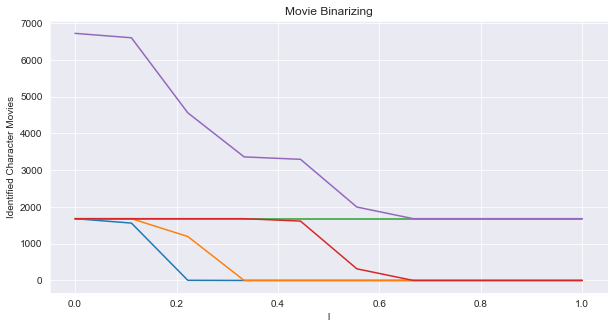

In [20]:
plt.plot(L,a)
plt.plot(L,b)
plt.plot(L,c)
plt.plot(L,d)
plt.plot(L,e)

plt.xlabel('l')
plt.ylabel('Identified Character Movies')
plt.gca().grid(which='minor')
plt.title('Movie Binarizing')
# plt.legend()
plt.show()

In [ ]:
L = np.linspace(0.7,0.9,10)
AB,NI = [],[]
for lA in L:
    A_hat_B = project_onto_face(A,l=lA)
    n_identified = A_hat_B.sum()
    AB.append(A_hat_B)
    NI.append(n_identified)

In [ ]:
# plt.plot(L,AB)
plt.plot(L,NI)

In [ ]:
def DatasetSelection():
    print("Executing Task 2")
def WeightingSelection():
    print("Executing Task 3")
def SolverSelection():
    for
    print("choose the solver and desired range")
def Assessment():
    print("running the below code")


# Create a list of tasks
all_tasks = [task1, task2, task3]

# Iterate over the tasks and execute them
for task in all_tasks:
    task()


In [ ]:
# Choosing Solver

# solver = 'GD'
# A = GD_solver(R_sa,M)

# solver = 'cvx'
# A = cvxSolver(R_sa,M)

# solver = 'nmf'
A = NimfaSolver(R_sa, k=4)

# solver = 'bmf'
# A = BinaryNimfaSolver(R_sa, M)

# Binarizing with different l
## R_sa_WC
#M:Wuhr
    # *lM = 0.8
    # GD *lA = 0.9775
    # cvx*lA = 0.77
    # nmf*lA = 0.76
    # bmf*lA = 0.77
#M:Clu
    # *lM = 0.2
    # GD  *lA = 0.53
    # cvx *lA = 0.7
    # nmf*lA = 0.775
    # bmf*lA = 0.77
    
## R_sa_NC
#M:Wuhr
    # *lM = 0.8
    # GD *lA = 0.9775
    # cvx*lA = 0.74
    # nmf*lA = 0.77
    # bmf*lA = 0.9
#M:Clu
    # *lM = 0.2
    # GD  *lA = 0.535
    # cvx *lA = 0.31
    # nmf*lA = 0.775
    # bmf*lA = 0.77
    
# result = []
# for lM in [0.18,0.2,0.22]:

for lM in [0.7,0.8,0.9]:
    lM = lM
    M_B= BinarizingM(M,l=lM)
    for lA in np.linspace(0.76,0.78,10):
        A_hat_B = project_onto_face(A,l=lA)
        n_identified = A_hat_B.sum()
        #Reconstruction
        Rr = MatrixReconstruction(R_sa,A_hat_B,M_B)
        # Assesment
        RMSE = ComputeRMSE(Rr)
        precision1, accuracy1, precision2, accuracy2,precision3, accuracy3, precision4, accuracy4 = UserIdentificationMeasure(SA, A_hat_B)
        data = [dataset_name, weighting, solver, lM, lA, n_identified, RMSE, (Rr != 0).sum(), precision1, accuracy1, precision2, accuracy2,precision3, accuracy3, precision4, accuracy4]
        result.append(data)
        
col=['datset name','weighting','solver', 'lM', 'lA', 'n_identified', 'RMSE','#ratings'
         ,'precision1','accuracy1','precision2','accuracy2'
         ,'precision3','accuracy3','precision4','accuracy4']
Result = pd.DataFrame(result,columns=col)
pd.DataFrame(Result).to_csv('InputData/Result.csv')

In [ ]:
# Choosing Solver
solver = 'bmf'
A = BinaryNimfaSolver(R_sa, M)

result2 = []
for lM in [0.18,0.2,0.22]:
    lM = lM
    M_B= BinarizingM(M,l=lM)
    for lA in np.linspace(0.76,0.78,10):
        A_hat_B = project_onto_face(A,l=lA)
        n_identified = A_hat_B.sum()
        #Reconstruction
        Rr = MatrixReconstruction(R_sa,A_hat_B,M_B)
        # Assesment
        RMSE = ComputeRMSE(Rr)
        precision1, accuracy1, precision2, accuracy2,precision3, accuracy3, precision4, accuracy4 = UserIdentificationMeasure(SA, A_hat_B)
        data = [dataset_name, weighting, solver, lM, lA, n_identified, RMSE, (Rr != 0).sum(), precision1, accuracy1, precision2, accuracy2,precision3, accuracy3, precision4, accuracy4]
        result2.append(data)
        
col=['datset name','weighting','solver', 'lM', 'lA', 'n_identified', 'RMSE','#ratings'
         ,'precision1','accuracy1','precision2','accuracy2'
         ,'precision3','accuracy3','precision4','accuracy4']
Result2 = pd.DataFrame(result2,columns=col)
pd.DataFrame(Result2).to_csv('InputData/Result2.csv')

Thank you

# _________________________________________________________

# Other materials

### Gradient Descent Solver 

In [204]:
 # Main Gradient descend solver
def GD_solver(V, H, p=1.1, max_iteration=20):
    '''
    V : is a mxn array
    H : is a kxn array
    '''
    m, n = V.shape   # Number of users and movies
    O = np.array(V != 0,dtype='float')   # Producing Observation matrix 
    k = H.shape[0]   # Number of features
    W = np.zeros((m,k),dtype=float)   # Initial point X0
    f = 0   # Initial objective value
    sequence = []   # for saving what happen in the iterations
    # Normalization
    for t in range(n):
        s = H.T[t].sum()
        if s == 0:
            s=1
        H.T[t] = H.T[t]/s
    # Main
    for iteration in range(max_iteration+1):
        f = (1/2) * np.linalg.norm((V - O*np.dot(W, H)), 'fro')**2 + (p/2)* np.linalg.norm((np.multiply(W,W)-W), 'fro')**2
        g = -1*(V - O*np.dot(W, H)).dot(H.T) + p * (2*W-np.ones((m,k)))*(np.multiply(W,W)-W)
        sequence.append([iteration, W, f, g])
        improvment =  sequence[iteration][2] - sequence[iteration-1][2]
        #stoping criterion
        if improvment > 0 or  iteration >= max_iteration:
            break       
        # Updating
        alpha = 1/(1+iteration)
        W = W-(alpha*g)
        p = p * p
        # Normalization
        for j in range(W.shape[0]):
            total = W[j].sum()
            if total ==0:
                total = 1
            W[j] = W[j]/total
        return W
#     return W, sequence
#     return col_balancing(W), sequence


In [ ]:
def softmax(x, temperature=1.0):
    """Compute softmax values for each set of scores in x."""
    x = np.array(x)
    x_scaled = x / temperature  # Scale by temperature
    e_x = np.exp(x_scaled - np.max(x_scaled))  # subtract the max for numerical stability
    return e_x / e_x.sum()

In [ ]:
A_softened = np.reshape(softmax(A, temperature=1.5),(784,4))

After applying softmax or other binarizing methods on A: account feature matrix and analysing UserIdentification (Confusion Matrix), it became clear that the best method for producing A_B: account membership matrix is my Projection onto face function.

In [5]:
def col_balancing(B = 'array_like_matrix'):
    m,k= B.shape
    miu= B.mean()
    b = [0]*k
    for i in range(k):
        b[i]= miu - B[:,i].mean()
        B[:,i] = B[:,i]+b[i]
        B[B<0]=0
    return B

### Partitioning method

In [7]:
## To reconstruct data matrix to incorporate identified users
# first partition R  into K submatrix Like Pimentel Full
# R[k] is the in omega_M[k]: we have the the desirable colomn indices of R[k]
def MatrixReconstruction(R_sa= 'mixture matrix', A_hat_B = 'account membership matrix', M_B = 'movie membership matrix'):
    '''
    partition the shared rating matrix to characters ratanings
    '''
    # nc : number of charactes
    nc = M_B.shape[0]
    
    omega_A = []
    for k in range(nc):
        omega_A.append(list(np.unique(np.where(A_hat_B[:,k]>0))))
    
    omega_M_B = []
    for k in range(nc):
        omega_M_B.append(list(np.unique(np.where(M_B[k,:]>0))))
    
    # Rp[nc] : the nc partition of R
    Rp = [np.zeros((R_sa.shape[0],R_sa.shape[1]),dtype='int') for i in range(nc)]
    for k in range(nc):
        for i in omega_A[k]:
            for j in omega_M_B[k]:
                Rp[k][i][j]= R_sa[i,j]
    
    # Reconstructing ratings matrix
    Rr = []   # reconstructed Rating matrix
    counter = 0
    identified_users_from_a_are = [[] for i in range(A_hat_B.shape[0])]
    for r in range(A_hat_B.shape[0]):
        pos = list(np.unique(np.where(A_hat_B[r]>0)))
        for i in pos:
            Rr.append(Rp[i][r])
            identified_users_from_a_are[r].append(r+counter)
            counter = counter+1
        counter = counter-1
    Rr = np.array(Rr)
    #return Rp, identified_users_from_a_are
    return Rr

In [8]:
# To compute the taste of each user type in each account
# To be computed for each account
def AccountReRating(A= 'account feature matrix', A_B, MN='movie feature matrix', a="account index"):
    K = A[a].shape[1]
    n = MN.shape[1]
    user_share_of_type= np.zeros((K,n))
    for k in range(K):
        for j in range(n):
            user_share_of_type[k,j] = A[a,k]*MN[k,j]
    user_share_of_type = user_share_of_type.reshape(1, -1) # turning the vector to row matrix
    normalized_user_share_of_type = normalize(user_share_of_type,axis=1, norm='l1')
    # Scaling ratings to [1, 5]
    rr = np.zeros(K) # new ratings
    for k in range(K):
        rr[k] = 1 + 4 * normalized_user_share_of_type[:, k]
    return rr

In [ ]:
pd.DataFrame(A_hat_B).to_csv('InputData/A_hat_B.csv')

# frame working for ilustration
label = ['Male','Female', 'Children','Family']
A_hat_B_df = pd.DataFrame(A_hat_B,columns=label)
A_hat_B_df.sum()

In [ ]:
print("#ratings Rsa_NC",n_ratings)
print("#ratings Rsa_WC",97531)

In [ ]:
def task1():
    print("Executing Task 1")

def task2():
    print("Executing Task 2")

def task3():
    print("Executing Task 3")

# Create a list of tasks
all_tasks = [task1, task2, task3]

# Iterate over the tasks and execute them
for task in all_tasks:
    task()


In [ ]:
RMSE_R_SVD = 0.9377, 6
RMSE_R_BaselineOnly = 0.9457, 0.5
RMSE_RCoClustering = 0.9693, 3
RMSE_R_KNNBaseline = 0.9326, 7

RMSE_Rsa_NC_SVD = 0.9438, 6
RMSE_Rsa_NC_BaselineOnly = 0.9509, 0.5
RMSE_Rsa_NC_CoClustering = 0.9703, 3
RMSE_Rsa_NC_KNNBaseline = 0.9381, 6

RMSE_Rsa_WC_SVD = 1.1067, 6
RMSE_Rsa_WC_BaselineOnly = 1.1107, 0.5
RMSE_Rsa_WC_CoClustering = 1.1331, 3
RMSE_Rsa_WC_KNNBaseline = 1.1011, 6

### * Torch solver

In [ ]:
import torch
# Assuming R and M are given as numpy arrays or torch tensors
# Convert them to torch tensors if they are not already
R = torch.tensor(R_sa, dtype=torch.float32, requires_grad=False)
M = torch.tensor(M, dtype=torch.float32, requires_grad=False)
solver = 'torch'

# Initialize A with random values
A = torch.randn((R.shape[0], M.shape[0]), dtype=torch.float32, requires_grad=True)
# Define the optimizer
optimizer = torch.optim.SGD([A], lr=0.01)
n_iterations = 1000
for _ in range(n_iterations):
    optimizer.zero_grad() 
    # Compute the prediction
    prediction = torch.matmul(A, M)   
    # Compute the loss (Frobenius norm of the difference)
    loss = (R - prediction).norm()  
    # Backpropagation
    loss.backward()    
    # Update A
    optimizer.step()

In [ ]:
import numpy as np
import tensorflow as tf

# Known Matrices
R = R_sa.astype(np.float32)  # Example rating matrix R
M = M.astype(np.float32)  # Example known movie feature matrix M
# Constants for the dimensions of the matrices
m, k, n = 784, 4, 1680  # m x k (X), k x n (M), m x n (R)



# TensorFlow Dataset to manage batches of R
dataset = tf.data.Dataset.from_tensor_slices(R)
dataset = dataset.batch(32)

# Prepare M as a constant tensor
M_tensor = tf.constant(M, dtype=tf.float32)

# Variable for X
X = tf.Variable(tf.random.uniform([m, k], minval=0, maxval=1, dtype=tf.float32), trainable=True)

# Define the optimizer
optimizer = tf.optimizers.Adam(learning_rate=1e-4)

# Loss function
def loss_function(predicted, target):
    return tf.reduce_mean(tf.square(predicted - target))

# Training step function
@tf.function
def train_step(R_batch, indices):
    with tf.GradientTape() as tape:
        # Get the corresponding batch of X based on indices
        X_batch = tf.gather(X, indices, axis=0)
        # Predict R using X_batch and M
        R_pred = tf.matmul(X_batch, M_tensor)
        # Calculate the loss
        loss = loss_function(R_pred, R_batch)
    # Get the gradients for X_batch
    gradients = tape.gradient(loss, [X_batch])
    # Apply gradients to the corresponding part of X
    optimizer.apply_gradients([(tf.IndexedSlices(gradients[0], indices), X)])
    return loss

# Training loop
epochs = 50
for epoch in range(epochs):
    for step, R_batch in enumerate(dataset):
        # Calculate batch indices
        batch_indices = tf.range(step * 32, min((step + 1) * 32, m))
        loss = train_step(R_batch, batch_indices)
        if step % 100 == 0:
            print(f"Epoch {epoch}, Step {step}, Loss: {loss.numpy()}")

# Fetch the final value of X
learned_X = X.numpy()
print("Learned User Features X Shape:", learned_X.shape)


### Neural Network and DEEP solvers

In [ ]:
import tensorflow as tf
import numpy as np

# # Constants for the dimensions of the matrices
# m, k, n = 784, 4, 1680  # m x k (X), k x n (M), m x n (R)

# # Known Matrices
# R = np.random.normal(size=(m, n)).astype(np.float32)  # Example rating matrix R
# M = np.random.normal(size=(k, n)).astype(np.float32)  # Example known movie feature matrix M


# Known Matrices
R = R_sa.astype(np.float32)  # Example rating matrix R
M = M.astype(np.float32)  # Example known movie feature matrix M
# Constants for the dimensions of the matrices
m, k, n = 784, 4, 1680  # m x k (X), k x n (M), m x n (R)


# Prepare M as a constant tensor
M_tensor = tf.constant(M, dtype=tf.float32)

# Initialize X as a trainable variable
X = tf.Variable(tf.random.uniform([m, k], 0, 1, dtype=tf.float32), trainable=True)

# Custom layer to compute X * M
class CustomMultiplyLayer(tf.keras.layers.Layer):
    def __init__(self, M):
        super(CustomMultiplyLayer, self).__init__()
        self.M = M

    def call(self, inputs):
        return tf.matmul(inputs, self.M)

# Build the model
input_layer = tf.keras.Input(shape=(k,))
multiply_layer = CustomMultiplyLayer(M_tensor)
output = multiply_layer(input_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Loss function to minimize the difference between R and X * M
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Fit model
def train_model(X, R, epochs=100):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            R_pred = multiply_layer(X)  # X * M
            loss = custom_loss(R, R_pred)
        grads = tape.gradient(loss, [X])
        optimizer.apply_gradients(zip(grads, [X]))
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Call the training function
train_model(X, R)

# Retrieve the learned user features matrix X
learned_X = X.numpy()
print("Learned User Features X Shape:", learned_X.shape)


In [ ]:
lA = 0.7
A_hat_B = project_onto_face(A,l=lA)
A_hat_B.sum()
n_identified = A_hat_B.sum()
print(n_identified)

In [ ]:
Rr = []   # reconstructed Rating matrix
counter = 0
identified_users_from_a_are = [[] for i in range(A_hat_B.shape[0])]
for r in range(A_hat_B.shape[0]):
    pos = list(np.unique(np.where(A_hat_B[r]>0)))
    for i in pos:
        Rr.append(Rp[i][r])
        identified_users_from_a_are[r].append(r+counter)
        counter = counter+1
    counter = counter-1
Rr = np.array(Rr)

In [ ]:
pd.DataFrame(Rp[0]).to_csv('InputData/Rp0.csv')
pd.DataFrame(Rp[1]).to_csv('InputData/Rp1.csv')
pd.DataFrame(Rp[2]).to_csv('InputData/Rp2.csv')
pd.DataFrame(Rp[3]).to_csv('InputData/Rp3.csv')

In [ ]:
Rr = []
for r in range(A_hat_B.shape[0]):
    pos = list(np.unique(np.where(A_hat_B[r]>0)))
    for i in pos:
        Rr.append(Rp[i][r])
Rr = np.array(Rr)
print(Rr.shape)

In [ ]:
pd.DataFrame(Rr).to_csv('InputData/Rr2.csv')

In [ ]:
# storing identified_users_from_a_are variable to pass it to another notebook
%store identified_users_from_a_are

In [ ]:
### Completing R_sa
# Input
matrix_to_be_completed = R_sa

from matrix_completion import svt_solve, calc_unobserved_rmse

I = np.identity(matrix_to_be_completed.shape[0])
# Producing Observation matrix 
O = np.array(matrix_to_be_completed != 0,dtype='float')  

# The best max_iterations is 3 and more than 6 do not work
R_hat = svt_solve(matrix_to_be_completed, O,max_iterations=3)
print("RMSE:", calc_unobserved_rmse(I, matrix_to_be_completed.T, R_hat, O))

### Analying

In [ ]:
# frame working for ilustration
label = ['Male','Female', 'Children','Family']
# A_hat_df = pd.DataFrame(A_hat,columns=label)
A_hat_B_df = pd.DataFrame(A_hat_B,columns=label)

In [ ]:
# The Identified character ratio
A_hat_B.sum()/943

In [ ]:
A_hat_B_df.sum()

In [ ]:
# To analyze the shared accounts: overally how many characters are in aour accounts
rowsum=[]
for i in range(A_hat_B.shape[0]):
    rowsum.append(A_hat_B[i,:].sum())
plt.hist(rowsum,bins=4)

_____

# Sensitivity Analysis for parameter tuning

In [ ]:
Y = []
L = np.linspace(0,1,100)
for i in L:
    a = project_onto_face(A_hat,l=i)
    r = a.sum()/782
    Y.append(r)
    
plt.plot(L,Y)
plt.xlabel('l')
plt.ylabel('Identified Characters per Account')
plt.gca().grid(which='minor')
# plt.title('Rating Consistency over Time')
plt.show()

### closer look

In [ ]:
Y = []
L = np.linspace(0.8,1,100)
for i in L:
    a = project_onto_face(A_hat,l=i)
    r = a.sum()/782
    Y.append(r)
    
plt.plot(L,Y)
plt.xlabel('l')
plt.ylabel('Identified Characters per Account')
plt.gca().grid(which='minor')
# plt.title('Rating Consistency over Time')
plt.show()

### closer look

In [ ]:
Y = []
L = np.linspace(0.97,1,100)
for i in L:
    a = project_onto_face(A_hat,l=i)
    r = a.sum()/782
    Y.append(r)
    
plt.plot(L,Y)
plt.xlabel('l')
plt.ylabel('Identified Characters per Account')
plt.gca().grid(which='minor')
# plt.title('Rating Consistency over Time')
plt.show()

### We choose the l parameter to be 0.975 emperically.

In [ ]:
Y,Y1,Y2 = [],[],[]
# Z = []
L = np.linspace(0,1,100)
for i in L:
    U_hat_B = project_onto_face(U_hat,l=i)
    U_hat_B_M = R_Mix_map(U_hat_B)
    U_hat_B_M[U_hat_B_M>0]=1
    U_hat_B_sa = project_onto_face(U_hat_sa,l=i)
    D = U_hat_B_M - U_hat_B_sa
    e = np.count_nonzero(D)/np.sum(U_hat_B_sa,where=[U_hat_B_sa>0])
    Y.append(e)
    Y1.append(np.count_nonzero(U_hat_B_M))
    Y2.append(np.count_nonzero(U_hat_B_sa))

In [ ]:
np.count_nonzero(D)

In [ ]:
np.sum(U_hat_B_sa,where=[U_hat_B_sa>0])

In [ ]:
e

In [ ]:
plt.plot(L,Y)
plt.xlabel('l')
plt.ylabel('NonConformity')
plt.gca().grid(which='minor')
# plt.title('Rating Consistency over Time')
plt.show()

In [ ]:
# plt.plot(L,Y1)
plt.plot(L,Y2)
# plt.ylim([0, 5])
plt.xlabel('l')
plt.ylabel('Identifeid Users')
plt.gca().grid(which='minor')
# plt.title('Rating Consistency over Time')
plt.show()

# Shared Account Ground Truth

In [ ]:
m_mix = len(sa1)+len(sa2)+len(sa3)+len(sa4)
places = [i for i in range(m_mix)]
np.random.seed(1337)
random_places_in_R_mix = []
for i in range(m_mix):
    j = np.random.randint(0,len(places))
    random_places_in_R_mix.append(places[j])
    places.pop(j)

In [ ]:
def R_Mix_map(Input):
    R = pd.DataFrame(Input)
    m,n = R.shape
    U_mix = np.zeros((m_mix,n),dtype=float)
    i=0
    j=0

    for counter in range(len(sa1)):
        U_mix[random_places_in_R_mix[i]]=R.iloc[list(sa1)[j],:]
        i = i+1
        j = j+1

    j=0
    for counter in range(len(sa2)):
        U_mix[random_places_in_R_mix[i]]=R.iloc[list(sa2[j])[0],:]+R.iloc[list(sa2[j])[1],:]
        i = i+1
        j = j+1

    j=0    
    for counter in range(len(sa3)):
        U_mix[random_places_in_R_mix[i]]=R.iloc[list(sa3[j])[0],:]+R.iloc[list(sa3[j])[1],:]+R.iloc[list(sa3[j])[2],:]
        i = i+1
        j = j+1

    j=0    
    for counter in range(len(sa4)):
        U_mix[random_places_in_R_mix[i]]=R.iloc[list(sa4[j])[0],:]+R.iloc[list(sa4[j])[1],:]+R.iloc[list(sa4[j])[2],:] +R.iloc[list(sa4[j])[3],:]
        i = i+1
        j = j+1
        
    return U_mix

In [ ]:
R_sa_manualy = R_Mix_map(R)

In [ ]:
# Test to be right = 0.
np.count_nonzero(R_sa_manualy - R_sa)

# To partition R  into K submatrix

R[k] is the 
in omega_M[k]: we have the the desirable colomn indices of R[k]

In [ ]:
# for every row of movie feature matrix, find the subset of colomn indecies that are nonzero
# in fact we are finding the movies that have the feature of k and save it in the k-th element of omega_M list
M = M_B
K = M.shape[0]
omega_M = []
for k in range(K):
    omega_M.append(list(np.unique(np.where(M[k,:]>0))))

In [ ]:
pd.DataFrame(M)

In [ ]:
# determining User feature indices for row indices of
# for ex omega_U_sa[1] is the set of indices that found to be children
K = A_hat_B.shape[1]
omega_A = []
for k in range(K):
    omega_A.append(list(np.unique(np.where(A_hat_B[:,k]>0))))

In [ ]:
R = R_sa

In [ ]:
R_k_0 =np.zeros((len(omega_A[0]),len(omega_M[0])))
for i in range(len(omega_A[0])):
    for j in range(len(omega_M[0])):
        R_k_0[i][j]= R[omega_A[0][i],omega_M[0][j]]

R_k_1 =np.zeros((len(omega_A[1]),len(omega_M[1])))
for i in range(len(omega_A[1])):
    for j in range(len(omega_M[1])):
        R_k_1[i][j]= R[omega_A[1][i],omega_M[1][j]]
        
R_k_2 =np.zeros((len(omega_A[2]),len(omega_M[2])))
for i in range(len(omega_A[2])):
    for j in range(len(omega_M[2])):
        R_k_2[i][j]= R[omega_A[2][i],omega_M[2][j]]
        
R_k_3 =np.zeros((len(omega_A[3]),len(omega_M[3])))
for i in range(len(omega_A[3])):
    for j in range(len(omega_M[3])):
        R_k_3[i][j]= R[omega_A[3][i],omega_M[3][j]]

In [ ]:
label0=omega_M[0]
label1=omega_M[1]
label2=omega_M[2]
label3=omega_M[3]

index0=omega_A[0]
index1=omega_A[1]
index2=omega_A[2]
index3=omega_A[3]
A_hat_df = pd.DataFrame(A_hat,columns=label)

In [ ]:
pd.DataFrame(R_k_0,columns=label0, index = index0).to_csv('Rp0.csv')
pd.DataFrame(R_k_1,columns=label1, index = index1).to_csv('Rp1.csv')
pd.DataFrame(R_k_2,columns=label2, index = index2).to_csv('Rp2.csv')
pd.DataFrame(R_k_3,columns=label3, index = index3).to_csv('Rp3.csv')

In [ ]:
c_sa = np.count_nonzero(R_sa)
m_sa,n_sa = R_sa.shape

c0=np.count_nonzero(R_k_0)
c1=np.count_nonzero(R_k_1)
c2=np.count_nonzero(R_k_2)
c3=np.count_nonzero(R_k_3)
m0,n0=R_k_0.shape
m1,n1=R_k_1.shape
m2,n2=R_k_2.shape
m3,n3=R_k_3.shape

In [ ]:
c_sa-(c0+c1+c2+c3)

In [ ]:
((m_sa*n_sa) - ((m0*n0)+(m1*n1)+(m2*n2)+(m3*n3)))/(m_sa*n_sa)

In [ ]:
# this is the indices of users that have the feature of k=0
omega_A[0]

In [ ]:
# it is indices of the movies or items in our data set that have the feature k = 0
omega_M[0]

In [ ]:
R_k_0

### Producing user-genre matrix, that indicates how much each user likes a genre.

In [ ]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
m_g_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation'
           , 'Children', 'Comedy','Crime', 'Documentary', 'Drama', 'Fantasy'
           , 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


data_set_path_users = "InputData/ml-100k/u.user"
data_set_path_ratings = "InputData/ml-100k/u.data"
data_set_path_movies = "InputData/ml-100k/u.item"
users = pd.read_csv(data_set_path_users,sep='|',names = u_cols)
ratings = pd.read_csv(data_set_path_ratings,sep='\t', names = r_cols).drop('timestamp',axis=1)
movies = pd.read_csv(data_set_path_movies, sep='|', names = m_cols, usecols=range(5))
movies_genre_df = pd.read_csv(data_set_path_movies, sep='|', names = m_g_cols).drop(['title', 'release_date', 'video_release_date', 'imdb_url'],axis=1)

In [ ]:
# Load the user demographic data
user_data = pd.read_csv(data_set_path_users, sep='|', names=['user_id', 'age', 'sex', 'occupation', 'zip_code'], engine='python')

# Display the first few rows to confirm we have the correct data this time
user_data.head()

In [ ]:
plt.hist(users["age"])

In [ ]:
plt.hist(users['sex'])

In [ ]:
users.sort_values(by='age')

In [ ]:
users[users['user_id'] == 1]

In [ ]:
ratings.sort_values('user_id')
ratings[ratings['user_id'] == 1].sort_values('rating',ascending=False)

In [ ]:
movies[movies['movie_id'] == 8]

In [ ]:
movies_genre_df[movies_genre_df['movie_id'] == 170]

In [ ]:
movies_genre_df.sum()

In [ ]:
ratings = np.array(pd.read_csv('InputData/R.csv'))

In [ ]:
# Create input function directly from numpy array.
R_u, R_i = ratings.nonzero()
R_s = ratings[ratings.nonzero()]
train_data = tf.data.Dataset.from_tensor_slices(
  ({"user": R_u, "item": R_i}, R_s))
train_data = train_data.shuffle(buffer_size=1000).repeat(count=None).batch(1)

# Build the factorization network.
class KerasMF:

  def __init__(self, R, k=3, l2=1e-4, with_bias=False):
    self.l2_reg = tf.keras.regularizers.l2(l2)
    self.m, self.n = R.shape
    self.k = k
    self.with_bias = with_bias
    self.model = self.create_model()

  def create_model(self):
    user_inputs = tf.keras.layers.Input(shape=(1,), name="user")
    item_inputs = tf.keras.layers.Input(shape=(1,), name="item")
    user_embeddings = tf.keras.layers.Embedding(
      input_dim=self.m, output_dim=self.k, name="user_embedding",
      embeddings_regularizer=self.l2_reg)(user_inputs)
    item_embeddings = tf.keras.layers.Embedding(
      input_dim=self.n, output_dim=self.k, name="item_embedding",
      embeddings_regularizer=self.l2_reg)(item_inputs)
    dots = tf.keras.layers.Dot(axes=-1, name="logits")([user_embeddings, item_embeddings])
    if self.with_bias:
      # The formal use of bias need a tf.keras.layers.Dense layer.
      # But since we are customizing our network architecture,
      # we will use the tf.keras.layers.Embedding layer to do the trick.
      user_biases = tf.keras.layers.Embedding(
        input_dim=self.m, output_dim=1, name="user_bias")(user_inputs)
      item_biases = tf.keras.layers.Embedding(
        input_dim=self.n, output_dim=1, name="item_bias")(item_inputs)
      dots = tf.keras.layers.Add()([dots, user_biases, item_biases])
    model = tf.keras.Model(
      name="matrix_factorizer",
      inputs=[user_inputs, item_inputs], outputs=dots)
    model.compile(
      optimizer=tf.keras.optimizers.SGD(),
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[
        tf.keras.metrics.MeanSquaredError()
      ]
    )
    print(model.summary())
    return model

keras_mf = KerasMF(R=ratings, with_bias=True)

In [ ]:
keras_mf.model.fit(train_data, epochs=10, steps_per_epoch=100, verbose=0)

In [ ]:
keras_preds = keras_mf.model.predict({"user": R_u, "item": R_i})
print(np.stack([np.squeeze(keras_preds),
               ratings[ratings.nonzero()]], axis=1))

### BinarizingA: Tresholding via perventile (Great result, 40% of two_user accounts were identified)

In [ ]:
A_hat_B = (U.value > np.percentile(U.value, 70)).astype(int)  # Using a percentile threshold
n_identified = A_hat_B.sum()
n_identified

### BinarizingA: Clustering (Terrible)

In [ ]:
# Get the continuous solution for U
U_continuous = U.value

# Apply k-means clustering to binarize U
kmeans = KMeans(n_clusters=2, random_state=0).fit(U_continuous)
labels = kmeans.labels_  # Labels for rows, each label applies to all features of the row

# Expand labels to all features in U
U_binary = np.array([labels] * k).T  # Transpose to match the shape of U

print("Binarized U matrix based on k-means clustering:")
print(U_binary)

In [ ]:
# K-means clusters labels as 0 or 1, which directly gives us the binary matrix
# If needed, map clusters to 0 and 1 based on centroids if not already so
centroids = kmeans.cluster_centers_
if np.mean(centroids[0]) > np.mean(centroids[1]):
    U_binary = 1 - U_binary  # Invert labels if 0 is closer to the higher centroid

In [ ]:
# Get the continuous solution for U
U_continuous = U.value

# Apply k-means clustering to binarize U
kmeans = KMeans(n_clusters=2, random_state=0).fit(U_continuous)
labels = kmeans.labels_  # Labels for rows, each label applies to all features of the row
centroids = kmeans.cluster_centers_  # Centroids of the clusters

# Determine which label corresponds to the higher and lower centroid
label_high = 0 if centroids[0].mean() > centroids[1].mean() else 1

# Create binary matrix based on the label associated with the higher centroid
U_binary = np.where(labels[:, None] == label_high, 1, 0)

print("Centroids:", centroids)
print("Label associated with the higher centroid:", label_high)
print("Binarized U matrix based on k-means clustering:")
print(U_binary)

In [ ]:
n_identified = U_binary.sum()
n_identified

In [ ]:
a = 637
print(np.round(softmax(U_continuous)[a],4))
print(np.round(U_continuous[a],4))
print(A_hat_B[a])

In [ ]:
A_softened_3 = np.reshape(softmax(U.value, temperature=2),(784,4))
A_softened_0 = np.reshape(softmax(U.value, temperature=0.5),(784,4))
A_hat_B_softened_3 = project_onto_face(A_softened_3,l = 0.9931)
A_hat_B_softened_0 = project_onto_face(A_softened_0,l = 0.9727)

print(A_hat_B_softened_3.sum())
print(A_hat_B_softened_0.sum())

In [ ]:
print('softened_3',UserIdentificationMeasure(SA,A_hat_B_softened_3)[2])
print('softened_0',UserIdentificationMeasure(SA,A_hat_B_softened_0)[2])
print('B_abs',UserIdentificationMeasure(SA,A_hat_B_abs)[2])
print('A_hat_B',UserIdentificationMeasure(SA,A_hat_B)[2])

In [ ]:
lA = 0.5189
A_hat_B_abs = project_onto_face(np.abs(U.value),lA)  # Using a percentile threshold

n_identified = A_hat_B.sum()
n_identified

In [ ]:
import cvxpy as cp
import numpy as np
import time

# Constants for the dimensions of the matrices
# m, k, n = 784, 4, 1680  # m x k (U), k x n (V), m x n (R)

m, n = R_sa.shape   # Number of accounts and movies
O = np.array(R_sa != 0,dtype='float')   # Producing Observation matrix 
k = M.shape[0]   # Number of features

R = R_sa.astype(np.float32)  # Example rating matrix R
V = M.astype(np.float32)  # Known item feature matrix V

V_constant = cp.Parameter((k, n), value=V)

U = cp.Variable((m, k), nonneg=True)  # Ensures U is non-negative

objective = cp.Minimize(cp.norm(R - cp.multiply(O,(U @ V_constant)), 'fro') + 0.1 * cp.norm(U, 1))


start_time = time.time()
problem = cp.Problem(objective)
result = problem.solve(solver=cp.SCS)
end_time = time.time()

print("Optimal value (loss):", result)
print("Learned matrix U with non-negativity constraint:", U.value)
print("Computation Time: {:.2f} seconds".format(end_time - start_time))

# A_hat_B = project_onto_face(A, l=0.44)

# آیا شافل شدن ردیف های ماتریس آر هم در خطای توصیه گر تاثیر داره؟
در فرایند محاسبه خود خطا که نداره،
اما در فرایند برآورد هر کدام از رتبه ها احتمالن داره با توجه به روش توصیه گر

In [158]:
shuffled_R_sa = R_sa[np.random.permutation(R_sa.shape[0]), :]
print("Original R:")
print(R_sa)
print("Newly shuffled R:")
print(shuffled_R_sa)

Original R:
[[0. 5. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [7. 4. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Newly shuffled R:
[[0. 0. 0. ... 0. 0. 0.]
 [3. 3. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 3. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [159]:
ComputeRMSE(R_sa)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


1.2509051327077652

In [160]:
ComputeRMSE(shuffled_R_sa)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


1.251690344110006

### ببینیم توصیه گر برای هر کاربر  چه توصیه هایی میکنه

In [184]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Sample data: user, item, rating
data = {
    'userID': ['A', 'A', 'A', 'B', 'B', 'C'],
    'itemID': ['1', '2', '3', '1', '3', '2'],
    'rating': [3, 2, 4, 2, 5, 3]
}
df = pd.DataFrame(data)

# Define a reader with the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the dataset from the dataframe
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Use the SVD algorithm, similar to Singular Value Decomposition in Matrix Factorization
model = SVD()
model.fit(trainset)
# Assuming you want to predict ratings for user 'A' for all items in the dataset
user_id = 0
items = df['itemID'].unique()  # All unique items

# Dictionary to store the predicted ratings
predicted_ratings = {}

for item_id in items:
    # Predict rating for each item
    prediction = model.predict(user_id, item_id)
    predicted_ratings[item_id] = prediction.est

print("Estimated ratings for user A:", predicted_ratings)


# Assuming you want to predict ratings for user 'A' for all items in the dataset
user_id = 'A'
items = df['itemID'].unique()  # All unique items

# Dictionary to store the predicted ratings
predicted_ratings = {}

for item_id in items:
    # Predict rating for each item
    prediction = model.predict(user_id, item_id)
    predicted_ratings[item_id] = prediction.est

print("Estimated ratings for user A:", predicted_ratings)


# Items that user 'A' has rated
rated_items = df[df['userID'] == user_id]['itemID'].unique()

# Predict ratings for unrated items only
predicted_ratings = {}
for item_id in items:
    if item_id not in rated_items:
        prediction = model.predict(user_id, item_id)
        predicted_ratings[item_id] = prediction.est

print("Estimated ratings for unrated items for user A:", predicted_ratings)



Estimated ratings for user A: {'1': 3.0013339098361467, '2': 2.910688876607268, '3': 3.0890550195012}
Estimated ratings for user A: {'1': 2.983929999800422, '2': 2.711401758551493, '3': 3.2430041025043463}
Estimated ratings for unrated items for user A: {}


In [243]:
import numpy as np

# Example Data
v = np.array([0, 1, 0, 5, 10, 0])  # Combined vector
a = 1  # Weight for c1
b = 1  # Weight for c2

# Assuming we know the non-overlapping indices:
# c1 is non-zero only at index 3, and c2 is non-zero at indices 1 and 4
c1_indices = [3]  # Example indices for c1
c2_indices = [1, 4]  # Example indices for c2

# Initialize c1 and c2 as zeros
c1 = np.zeros_like(v)
c2 = np.zeros_like(v)

# Calculate c1 and c2 based on non-overlapping assumption
c1[c1_indices] = v[c1_indices] / a
c2[c2_indices] = v[c2_indices] / b

# Output the vectors
c1, c2


(array([0, 0, 0, 5, 0, 0]), array([ 0,  1,  0,  0, 10,  0]))